- Import Packages

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from mkit.torch_support.tensor_utils import x_y_sequences, xy_to_tensordataset
from mkit.torch_support.nn_utils import training_loop
from mkit.torch_support.model import TimeSeriesTransformer

ImportError: cannot import name 'TimeSeriesTransformer' from 'mkit.torch_support.model' (c:\Users\ss348\anaconda3\Lib\site-packages\mkit\torch_support\model\__init__.py)

- Data Generation

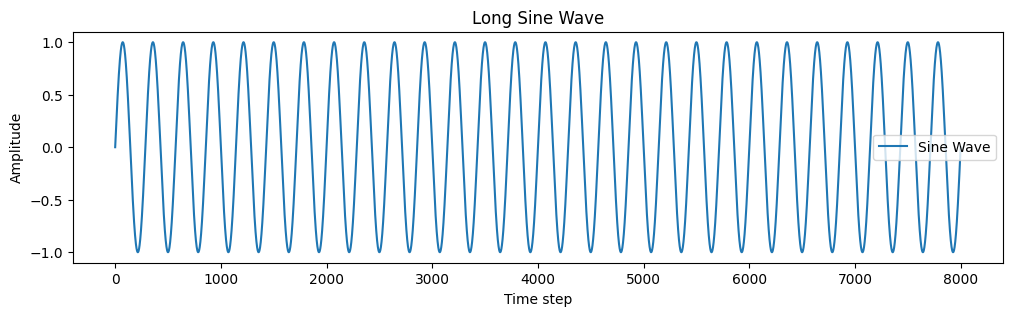

In [46]:

def generate_long_sine_wave(total_steps, freq=1, phase=0, amplitude=1, noise_std=0.0):
    """
    Generates a long sine wave of length total_steps.
    
    Returns:
      - sine_wave: Numpy array of shape (total_steps,) containing the sine wave data.
    """
    t = np.linspace(0, 2 * np.pi, total_steps)
    sine_wave = amplitude * np.sin(freq * t + phase)
    if noise_std > 0:
        sine_wave += np.random.normal(scale=noise_std, size=sine_wave.shape)
    return sine_wave

total_steps = 8000   # total number of time steps in the long sine wave.
freq = 28
phase = 0
amplitude = 1
noise_std = 0

# Generate the long sine wave.
sine_wave = generate_long_sine_wave(total_steps, freq=freq, phase=phase, amplitude=amplitude, noise_std=noise_std)

# Visualize the long sine wave.
plt.figure(figsize=(12, 3))
plt.plot(sine_wave, label="Sine Wave")
plt.title("Long Sine Wave")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

- Data Splitting

In [ ]:

# Define sequence extraction parameters.
seq_len = 270     # Length of each input sequence.
forecast_horizon = 1 # For reconstruction; use a positive value for forecasting future steps.
train = sine_wave[:int(len(sine_wave) * .8)]
test = sine_wave[int(len(sine_wave) * .8):]
# Create sequences from the sine wave.
x_all, y_all = x_y_sequences(train, seq_len, forecast_horizon)

print(f"Total sequences generated: {x_all.shape[0]}")  # Print number of sequences.

# Split the sequences into training and testing sets.
split_ratio = 0.8
num_train = int(split_ratio * x_all.shape[0])
x_train, y_train = x_all[:num_train], y_all[:num_train]
x_test, y_test = x_all[num_train:], y_all[num_train:]

print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

- Model

Total sequences generated: 6130
Training set shape: torch.Size([4904, 270, 1]) torch.Size([4904, 270, 1])
Testing set shape: torch.Size([1226, 270, 1]) torch.Size([1226, 270, 1])


EPOCH 1/16: 100%|██████████| 154/154 [00:02<00:00, 74.65it/s]


Epoch [1/16] Training Loss: 0.0113 

EPOCH 2/16: 100%|██████████| 154/154 [00:01<00:00, 86.98it/s]


Epoch [2/16] Training Loss: 0.0028 

EPOCH 3/16: 100%|██████████| 154/154 [00:01<00:00, 85.46it/s]


Epoch [3/16] Training Loss: 0.0023 

EPOCH 4/16: 100%|██████████| 154/154 [00:01<00:00, 86.79it/s]


Epoch [4/16] Training Loss: 0.0023 

EPOCH 5/16: 100%|██████████| 154/154 [00:01<00:00, 84.22it/s]


Epoch [5/16] Training Loss: 0.0023 

EPOCH 6/16: 100%|██████████| 154/154 [00:01<00:00, 83.54it/s]


Epoch [6/16] Training Loss: 0.0023 

EPOCH 7/16: 100%|██████████| 154/154 [00:01<00:00, 86.30it/s]


Epoch [7/16] Training Loss: 0.0022 

EPOCH 8/16: 100%|██████████| 154/154 [00:01<00:00, 85.61it/s]


Epoch [8/16] Training Loss: 0.0022 

EPOCH 9/16: 100%|██████████| 154/154 [00:01<00:00, 81.48it/s]


Epoch [9/16] Training Loss: 0.0022 

EPOCH 10/16: 100%|██████████| 154/154 [00:01<00:00, 80.80it/s]


Epoch [10/16] Training Loss: 0.0022 

EPOCH 11/16: 100%|██████████| 154/154 [00:01<00:00, 84.80it/s]


Epoch [11/16] Training Loss: 0.0022 

EPOCH 12/16: 100%|██████████| 154/154 [00:01<00:00, 79.77it/s]


Epoch [12/16] Training Loss: 0.0022 

EPOCH 13/16: 100%|██████████| 154/154 [00:01<00:00, 81.12it/s]


Epoch [13/16] Training Loss: 0.0022 

EPOCH 14/16: 100%|██████████| 154/154 [00:01<00:00, 80.07it/s]


Epoch [14/16] Training Loss: 0.0022 

EPOCH 15/16: 100%|██████████| 154/154 [00:01<00:00, 80.72it/s]


Epoch [15/16] Training Loss: 0.0022 

EPOCH 16/16: 100%|██████████| 154/154 [00:01<00:00, 83.84it/s]


Epoch [16/16] Training Loss: 0.0022 Training complete.


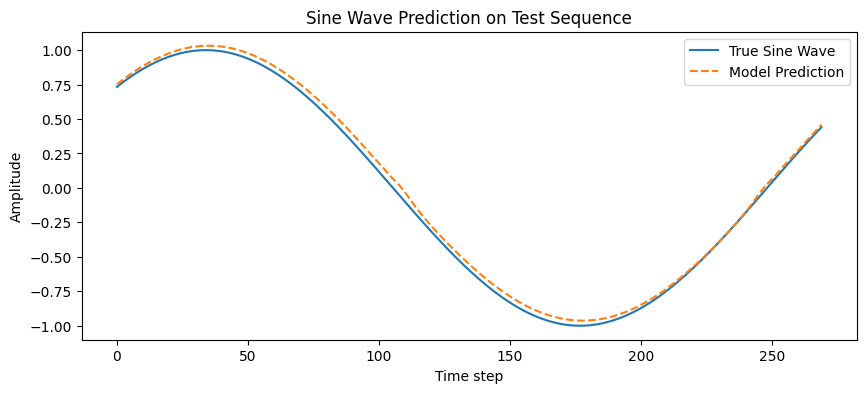

In [ ]:


print("Set up LLM model and declare params...")
input_dim = 1
model_dim = 32
output_dim = 1
num_layers = 2
batch_size = 32
num_epochs = 16
device = torch.device('cuda')

model = TimeSeriesTransformer(input_dim, model_dim, output_dim, num_layers=num_layers, num_heads=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = xy_to_tensordataset(x_train, y_train, return_loader=True)
test_loader = xy_to_tensordataset(x_test, y_test, return_loader=True)
training_loop(
    model=model,
    device=device,
    train_loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=num_epochs
)
# --------------------------------------
# Example Inference and Visualization
# --------------------------------------
model.eval()
with torch.no_grad():
    # Use one batch from the test set.
    for x_sample, y_sample in test_loader:
        x_sample = x_sample.to(device)
        prediction = model(x_sample)
        break

# Convert tensors to numpy for plotting.
x_sample = x_sample.cpu().numpy()
y_sample = y_sample.cpu().numpy()
prediction = prediction.cpu().numpy()

# Plot the first sequence in the batch.
plt.figure(figsize=(10, 4))
plt.plot(y_sample[0].squeeze(), label="True Sine Wave")
plt.plot(prediction[0].squeeze(), label="Model Prediction", linestyle="--")
plt.title("Sine Wave Prediction on Test Sequence")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


- Evaluation

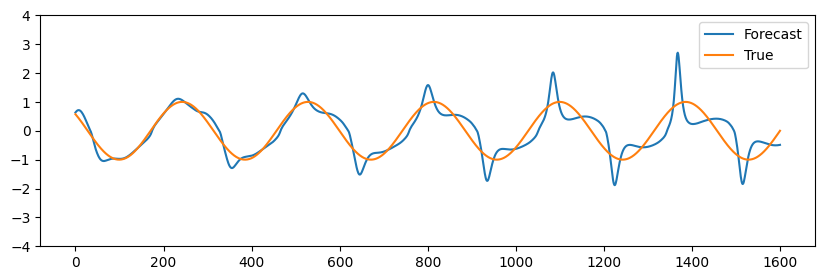

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Set the model to CPU and evaluation mode.
model.to(device)
model.eval()

last_seq = x_all[-1:, :, :]  # shape: (1, seq_len, input_dim)

total_forecast_points = len(test)
pred = []  # to collect forecasted values

current_input = last_seq.clone()  # Use a clone so that we do not modify original x_all.

while len(pred) < total_forecast_points:
    with torch.no_grad():
        forecast = model(current_input.to(device))  # shape: (1, seq_len, input_dim)
    next_forecast = forecast[:, -forecast_horizon:, :]  # (1, forecast_horizon, input_dim)
    pred.append(next_forecast.squeeze(0)[:, 0].cpu().detach().numpy())
    current_input = torch.cat([current_input[:, forecast_horizon:, :].to(device), next_forecast], dim=1)

pred = np.concatenate(pred)[:total_forecast_points]

plt.figure(figsize=(10, 3))
plt.plot(pred, label="Forecast")
plt.plot(test, label="True")
plt.ylim(-4, 4)
plt.legend()
plt.show()
